# Linear Regression (From Scratch)
In the following notebook, my goal is to demonstrate an understanding of linear regression by building a linear regression model from scratch.

## What is Linear Regression?
Linear regression is a statistical method used to model the relationship between a dependent variable $Y$ and one or more independent variables $X$. It assumes a linear relationship between the variables, where the dependent variable can be expressed as a linear function of the independent variables plus an error term.

For a simple linear regression with one independent variable $X$, the model is:
$Y=β_0 + β_1X+ϵ$

For multiple linear regression with multiple independent variables $X_1, X_2, ..., X_p$, the model is:
$Y=β_0+β_1X_1+β_2X_2+...+β_pX_p+ϵ$

where:
- $Y$ is the dependent variable,
- $X$ is the independent variable,
- $β_0$ is the intercept,
- $β_n$ is the coefficient (contributes to slope)
- $ϵ$ is the error term

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt

In [188]:
# Load in the diabetes dataset from SKLearn, only instance of SKLearn to be used in this notebook
X, y = load_diabetes(return_X_y=True, as_frame=True, scaled=False)
diabetes_data = X
diabetes_data['target'] = y
display(diabetes_data)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0,178.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0,104.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0,132.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0,220.0


# About the Dataset
Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

## Data Set Characteristics:
Number of Instances: 442

Number of Attributes: First 10 columns are numeric predictive values

**Target**: Column 11 is a quantitative measure of disease progression one year after baseline

Attribute Information:
- Age (years)
- sex
- bmi (body mass index)
- bp (average blood pressure)
- s1 (total serum cholesterol)
- s2 (low-density lipoproteins)
- s3 (high-density lipoproteins)
- s4 (total cholesterol / HDL)
- s5 (possibly(?) log of serum triglycerides level)
- s6 (blood sugar levels)

Source URL: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see: Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) “Least Angle Regression,” Annals of Statistics (with discussion), 407-499. (https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf)

Going to use BMI as the independent variable for demonstrating simple linear regression

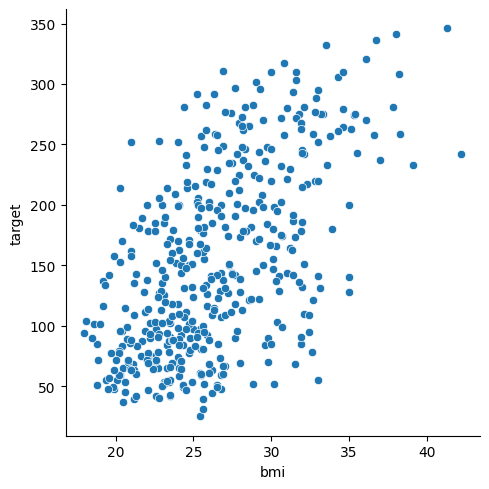

In [3]:
import seaborn as sns

sns.relplot(data = diabetes_data, x='bmi', y='target')

A general correlation is seen between BMI and the progression of diabetes one year after baseline. Time to make a regression.

# Ordinary Least Squares for Simple Linear Regression

In [171]:
# TODO spruce up function docstrings
# TODO Add MSE for comparing if it's good or bad
def OrdinaryLeastSquares(X_train, y_train):
    '''
    This function uses Ordinary Least Sqaures to calculate:
    m=N∑XY−(∑X∑Y)/(N∑X^2−(∑X)^2)
    b=N∑Y−m∑X
    Where the formula for the regression line is:
    Y=mX+b
    This function returns m (slope), and b (intercept)
    '''
    #X_train = np.array(X_train)
    #y_train = np.array(y_train)
    N = X_train.shape[0]

    sum_xy = (X_train * y_train).sum()
    sum_x = X_train.sum()
    sum_y = y_train.sum()
    sum_x_sq = (X_train**2).sum()

    m = (N*sum_xy - (sum_x*sum_y))/(N*sum_x_sq - sum_x**2)
    b = (sum_y - m*sum_x)/N
    
    return m, b
    
def train_test_split(X, y, test_size=.25, random_state=None):
    '''
    Parameters:
    -----------
    X: array-like independent variables/features
    y: array-like dependent variable/target
    test_size: float, (default=.25), proportion of data to include in test
    random_state: int, controls data shuffling
    
    Returns:
    --------
     X_train, X_test, y_train, y_test
    '''
    if random_state is not None:
        np.random.seed(random_state)
    
    X = np.array(X)
    y = np.array(y)

    n_total = len(X)
    n_test = int(n_total * test_size)

    # Create array of possible indices in X and y, then shuffle them with random
    indices = np.arange(n_total)
    np.random.shuffle(indices)

    # Split indices based on test size proportion
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]

    # Split X and y, assigning them data based on the randomized indices
    X_train = X[train_indices]
    X_test = X[test_indices]
    y_train = y[train_indices]
    y_test = y[test_indices]
    
    return X_train, X_test, y_train, y_test

def predict(X_test, m, b):
    '''
    This function will return a list of predictions from a given X
    requires m and b for the regression line
    '''
    return m * X_test + b
    

In [5]:
# Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# We just want BMI for this, so pass it only BMI values
bmi_train = X_train[:, 2]
bmi_test = X_test[:, 2]
m, b = OrdinaryLeastSquares(bmi_train, y_train)
# preds = predict(bmi_test, m, b)

# Plotting The Results

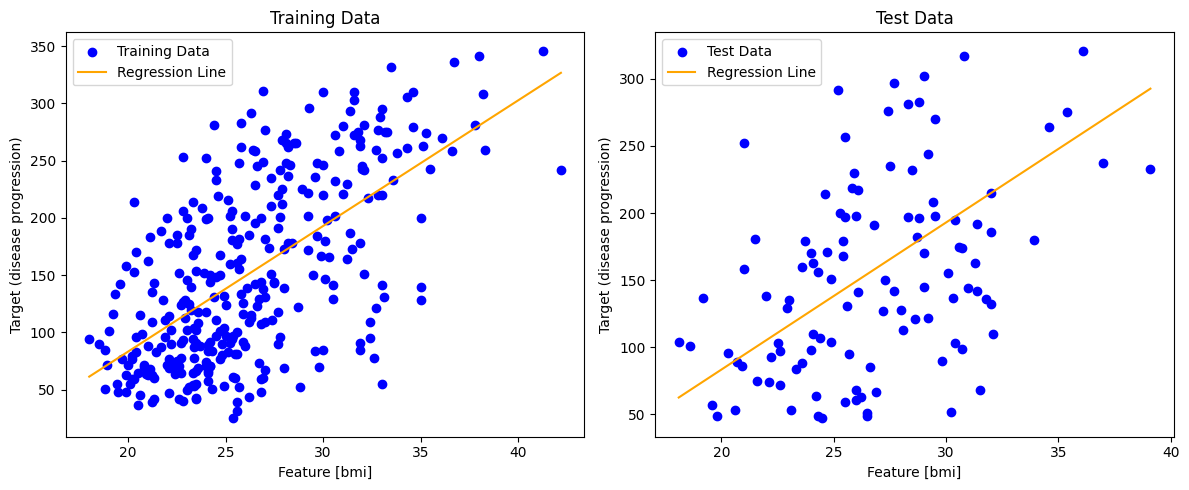

In [6]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
# Plot training data
ax1.scatter(bmi_train, y_train, color='blue', label='Training Data')
# Compute regression line for training data
line_x = np.array([bmi_train.min(), bmi_train.max()])
line_y = m * line_x + b
ax1.plot(line_x, line_y, color='orange', label='Regression Line')
    
ax1.set_title('Training Data')
ax1.set_xlabel('Feature [bmi]')
ax1.set_ylabel('Target (disease progression)')
ax1.legend()
    
# Plot test data
ax2.scatter(bmi_test, y_test, color='blue', label='Test Data')
# Compute regression line for test data
line_x = np.array([bmi_test.min(), bmi_test.max()])
line_y = m * line_x + b
ax2.plot(line_x, line_y, color='orange', label='Regression Line')
    
ax2.set_title('Test Data')
ax2.set_xlabel('Feature [bmi]')
ax2.set_ylabel('Target (disease progression)')
ax2.legend()
    
# Adjust layout and show plot
plt.tight_layout()
plt.show()

We also want to show a statistical summary of what we found.

# TODO
Explain each term, what it means, and it's importance

In [7]:
# TODO add in and understand the equations used
# TODO Add in SE, t, and p for slope and intercept. (The) Math is currently too complicated for me.
def regression_summary(X, y, m, b):
    '''
    Parameters:
    ----------

    Returns:
    --------
    '''
    n = len(X)
    preds = predict(X, m, b)
    residuals = [y_n - y_hat for y_n, y_hat in zip(y, preds)]

    # R-squared
    ss_total = sum((y_n - y.mean())**2 for y_n in y)
    ss_residual = sum(r**2 for r in residuals)
    r_squared = 1 - (ss_residual / ss_total)

    # Adjusted R-squared
    k = 1 #One predictor
    adjusted_r_squared = 1-(1-r_squared)*(n-1)/(n-k-1)
    
    # MSE and RMSE
    mse = ss_residual / n
    rmse = mse**.5
    
    # Print Summary
    print(f"Intercept (b): {b:.4f}")
    print(f"Slope (m): {m:.4f}")
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    print(f"R-squared: {r_squared:.4f}, Adjusted R-squared: {adjusted_r_squared:.4f}\n")
    
regression_summary(bmi_train, y_train, m, b)
regression_summary(bmi_test, y_test, m, b)

Intercept (b): -135.8885
Slope (m): 10.9619
MSE: 3796.8329, RMSE: 61.6184
R-squared: 0.3912, Adjusted R-squared: 0.3894

Intercept (b): -135.8885
Slope (m): 10.9619
MSE: 4219.5145, RMSE: 64.9578
R-squared: 0.1567, Adjusted R-squared: 0.1489



# Gradient Descent for Multiple Linear Regression
Steps:
1. Take the derivative of the Loss Function for each parameter in it. (Take the Gradient of the Loss Function)
    - Loss Function will be Sum of Squared Residuals
2. Pick random values for the parameters
3. Plug the parameter values into the derivatives (Gradient)
4. Calculate the step size (step size = slope * learning rate)
5. Calculate new parameters (new parameter = old parameter - step size)
6. Repeat 3-5 until stopping condition met (number of iterations or threshold of convergence met

In [257]:
class MultipleLinearRegression:
    def __init__(self, learning_rate=0.01, iterations=1000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.weights = None
        self.bias = None
        self.cost_history = []
        
    def fit(self, X, y):
        # Initialize parameters (weights and bias)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        
        # Gradient descent
        for i in range(self.iterations):
            # Make predictions with current parameters
            y_predicted = self._predict(X)
            
            # Calculate gradients
            # For weights
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            # For bias
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            # Calculate and store cost
            cost = (1/(2*n_samples)) * np.sum((y_predicted - y)**2)
            self.cost_history.append(cost)
            
            # Optional: Print cost every 100 iterations
            if (i+1) % 100 == 0:
                print(f'Iteration {i+1}/{self.iterations} | Cost: {cost:.4f}')
        
        return self
    
    def _predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def predict(self, X):
        return self._predict(X)
    
    def plot_cost_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(self.iterations), self.cost_history)
        plt.title('Cost History')
        plt.xlabel('Iteration')
        plt.ylabel('Cost')
        plt.grid(True)
        plt.show()

In [260]:
# Create a simple dataset
X = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y = np.array([3, 7, 11, 15])  # Linearly related to X

# Instantiate and fit your model
model = MultipleLinearRegression(learning_rate=0.01, iterations=1000)
model.fit(X, y)

# Check if weights and bias are reasonable
print(f"Weights: {model.weights}, Bias: {model.bias}")

Iteration 100/1000 | Cost: 0.0038
Iteration 200/1000 | Cost: 0.0021
Iteration 300/1000 | Cost: 0.0012
Iteration 400/1000 | Cost: 0.0007
Iteration 500/1000 | Cost: 0.0004
Iteration 600/1000 | Cost: 0.0002
Iteration 700/1000 | Cost: 0.0001
Iteration 800/1000 | Cost: 0.0001
Iteration 900/1000 | Cost: 0.0000
Iteration 1000/1000 | Cost: 0.0000
Weights: [0.99392049 1.00350304], Bias: 0.009582542301470974


Iteration 100/1000 | Cost: 1.9088
Iteration 200/1000 | Cost: 0.2683
Iteration 300/1000 | Cost: 0.1138
Iteration 400/1000 | Cost: 0.0972
Iteration 500/1000 | Cost: 0.0951
Iteration 600/1000 | Cost: 0.0947
Iteration 700/1000 | Cost: 0.0946
Iteration 800/1000 | Cost: 0.0946
Iteration 900/1000 | Cost: 0.0946
Iteration 1000/1000 | Cost: 0.0946
True weights: [ 2.  -3.5  1. ], True bias: 4.0
Learned weights: [ 1.95989626 -3.52513838  0.94594268], Learned bias: 4.056661972850312


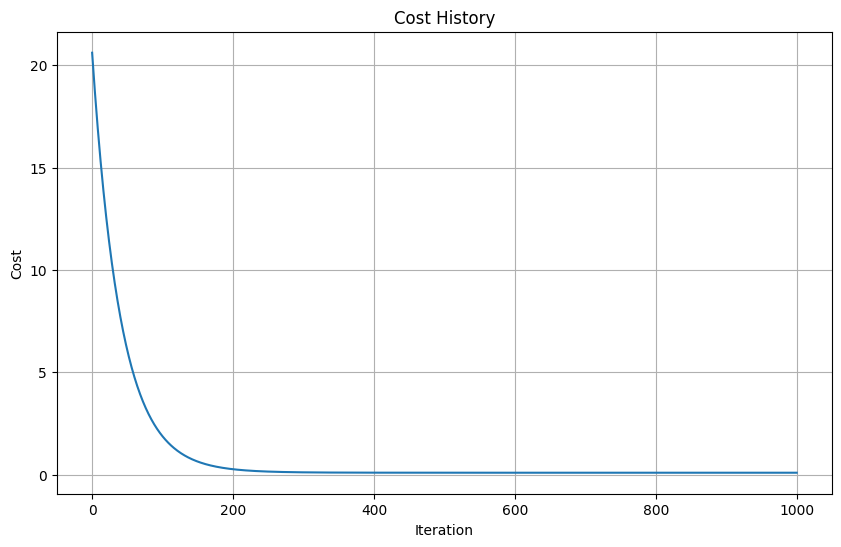

In [261]:
# Generate some sample data
np.random.seed(42)
X = np.random.randn(100, 3)  # 100 samples, 3 features

#df = pd.DataFrame(X)
#df.to_csv('X.csv')

true_weights = np.array([2.0, -3.5, 1.0])
true_bias = 4.0
y = np.dot(X, true_weights) + true_bias + np.random.randn(100) * 0.5

#df = pd.DataFrame(y)
#df.to_csv('y.csv')
    
# Train the model
model = MultipleLinearRegression(learning_rate=0.01, iterations=1000)
model.fit(X, y)
    
# Check learned parameters
print(f"True weights: {true_weights}, True bias: {true_bias}")
print(f"Learned weights: {model.weights}, Learned bias: {model.bias}")
    
# Plot cost history
model.plot_cost_history()

**Despite my best efforts, I could not get the diabetes dataset to work with my MultipleLinearRegression class, despite hours of looking at the data to understand what could possibly be going wrong. I would love to return to this to understand why either the data or my class is failing, but since synthetic data is working just fine, I'd rather demonstrate the capability of the work I've done with multiple linear regression than spend valuable time making one specific dataset work with a bespoke class I'll never use outside this project.**

Iteration 100/1000 | Cost: 4675.3021
Iteration 200/1000 | Cost: 3285.2972
Iteration 300/1000 | Cost: 3079.9626
Iteration 400/1000 | Cost: 3033.6719
Iteration 500/1000 | Cost: 3009.0079
Iteration 600/1000 | Cost: 2987.5536
Iteration 700/1000 | Cost: 2966.8359
Iteration 800/1000 | Cost: 2946.5177
Iteration 900/1000 | Cost: 2926.5484
Iteration 1000/1000 | Cost: 2906.9158
Learned weights: [  6.72731504   1.72743121  23.05429208  16.34377158   7.36222214
   5.53304903 -15.33934345  16.10667325  21.84042063  14.36700962], Learned bias: 152.024360510906


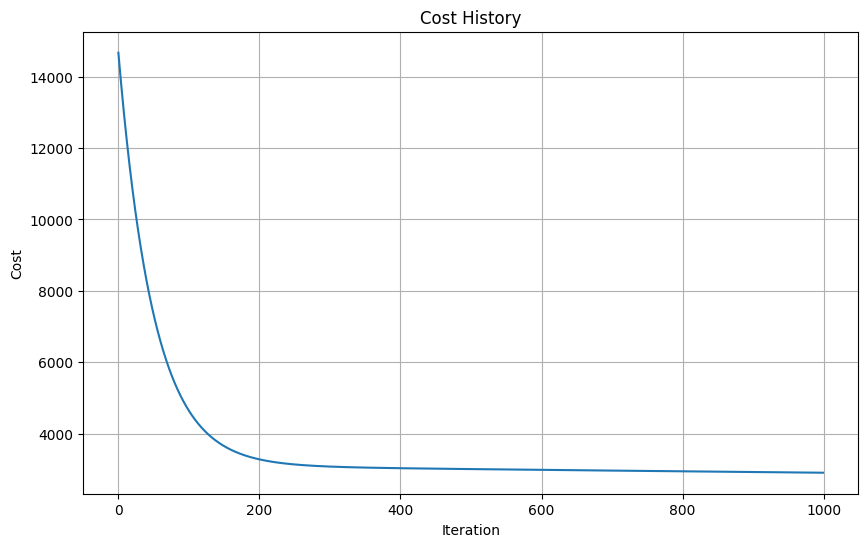

In [266]:
# Using the Multiple Linear Regression Class
X, y = load_diabetes(return_X_y=True, as_frame=False, scaled=True)
# Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#df = pd.DataFrame(X_train)
#df.to_csv('X_train.csv')

# Standardize, very important!
#X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
#X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
#y_standard = (y - y.mean(axis=0)) / y.std(axis=0)

#df = pd.DataFrame(y_train)
#df.to_csv('y_train_standard.csv')

#true_weights = np.array([2.0, -3.5, 1.0, .5, 1.0, 1.5, 2.0, -2.0, -1.5, -1.0])
#true_bias = 4.0
#print(X_train.shape)
#y_train = np.dot(X_train, true_weights) + true_bias + np.random.randn(X_train.shape[0]) * 0.5
#print(y_train.shape)

# SOMETHING IS WRONG WITH MY VALUES AND I DON'T KNOW WHAT
# Addendum: I wasn't standardizing my test features. Oops!
model = MultipleLinearRegression(iterations=1000)
model.fit(X_train, y_train)

print(f'Learned weights: {model.weights}, Learned bias: {model.bias}')

# Plot cost history
model.plot_cost_history()

In [265]:
# Let's compare our coef to the ones generated by sklearn!
from sklearn.linear_model import LinearRegression

# Using the Multiple Linear Regression Class
X, y = load_diabetes(return_X_y=True, as_frame=True, scaled=True)
# Create the training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

coefficients = sklearn_model.coef_
intercept = sklearn_model.intercept_

np.set_printoptions(suppress=True)
print(f"Coefficients: {coefficients}") 
print(f"Intercept: {intercept}")

print(model.predict(X_test))
print(sklearn_model.predict(X)[1])

Coefficients: [ -43.83240026 -209.56222163  593.6442307   301.83639293 -558.45714382
  258.53785369   -7.07169429  139.87458192  701.10058997   28.9847114 ]
Intercept: 153.01360145107097
[156.10505946 156.8539853  153.10300573 149.70114976 151.54968739
 155.72624759 148.94176517 155.22635695 149.17243807 153.5476796
 150.10158148 155.65636452 148.79108066 146.53836308 159.25870175
 148.27709937 150.1532122  146.17164314 145.87458122 157.13612354
 151.75893897 150.1699225  153.09934844 148.89950354 155.36850729
 153.15076732 149.59180749 147.2847398  152.47876771 154.04977492
 154.91547147 147.18724616 149.04453234 151.68547304 154.45128333
 153.62975545 153.05223771 154.90899545 150.94015035 154.92151187
 148.27725116 154.64587633 152.75148019 152.00851849 155.45796536
 147.29346534 150.6147579  150.6032983  152.75393444 156.50029199
 151.84392136 147.85279674 151.64733267 153.79016574 155.20482531
 156.33214742 155.61224621 146.59642363 154.12026055 154.7800513
 152.81711412 150.76919

In [267]:
# How does my model compare to SKLearn's? We're going to use MSE and RMSE to compare.
from sklearn.metrics import mean_squared_error

preds_sklearn = sklearn_model.predict(X_test)
mse_sklearn = mean_squared_error(y_test, preds_sklearn)

preds_bespoke = model.predict(X_test)
residuals_bespoke = [y_n - y_hat for y_n, y_hat in zip(y_test, preds_bespoke)]
ss_total = sum((y_n - y_test.mean())**2 for y_n in y_test)
ss_residual_bespoke = sum(r**2 for r in residuals_bespoke)
mse_bespoke = ss_residual_bespoke / y_test.shape[0]

print(mse_sklearn**.5)
print(mse_bespoke**.5)

56.61905786487867
68.68122882055344


https://statisticsbyjim.com/regression/least-squares-regression-line/
Calc least squares 

    # R-squared
    ss_total = sum((y_n - y.mean())**2 for y_n in y)
    ss_residual = sum(r**2 for r in residuals)
    r_squared = 1 - (ss_residual / ss_total)

    # Adjusted R-squared
    k = 1 #One predictor
    adjusted_r_squared = 1-(1-r_squared)*(n-1)/(n-k-1)
    
    # MSE and RMSE
    mse = ss_residual / n
    rmse = mse**.5